### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow            as tf
import tensorflow.keras      as keras
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (
    MaxPooling2D,
    AvgPool2D,
    Input,
    InputLayer,
    Dropout,
    Flatten,
    Dense,
    Lambda,
    Add
)
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot     as plt
import pandas                as pd

import skimage
import skimage.transform
import numpy as np

In [3]:
from tensorflow.keras.utils import plot_model

In [4]:
import sys
sys.path.append('../utilities/')
from utilities import (
    Timer,
    show_image,
    vgg19_process_image,
    class_names,
    Source,
    get_image_from_model,
    load_image,
    precomputed_loss
)

# Version 1: Unconstrained

### Setup

In [48]:
width = height = 896

In [49]:
# Load the model
# model_name = 'vgg19-INet-down2-b'
# base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### Unconstrained VGG19 Dream

In [50]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image')

signal = image_layer(input_)

output_layers = {
    'block5_pool' : 1.0
}

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
        activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn

for layer in base_model.layers:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dense):
        break
    signal = layer(signal)
    if layer.name in output_layers:
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]))
        total_activation = summarizer_layer(signal)
        outputs.append(total_activation)
        
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)
    

model = Model(inputs = input_, outputs = final_output)

In [51]:
# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

In [52]:
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [53]:
adam = tf.optimizers.Adam(learning_rate = 1.0)
model.compile(optimizer = adam, loss = precomputed_loss)
history = model.fit(dummy_input.repeat(100), epochs = 3)

Epoch 1/3
100/100 [==============================] - 12s 116ms/step - loss: -46026.1173
Epoch 2/3
100/100 [==============================] - 11s 111ms/step - loss: -574169.5797
Epoch 3/3
100/100 [==============================] - 11s 111ms/step - loss: -2119855.2666


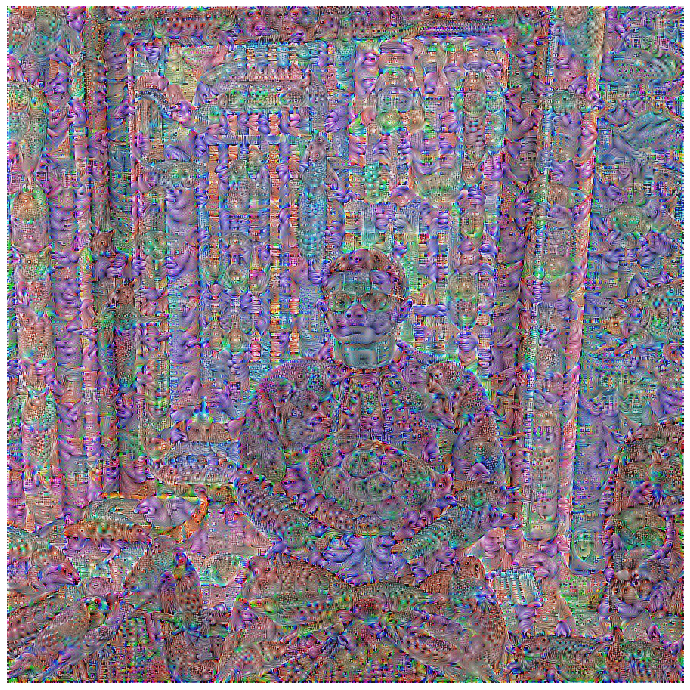

In [54]:
# With ImageNet model
img = get_image_from_model(model)
show_image(img)

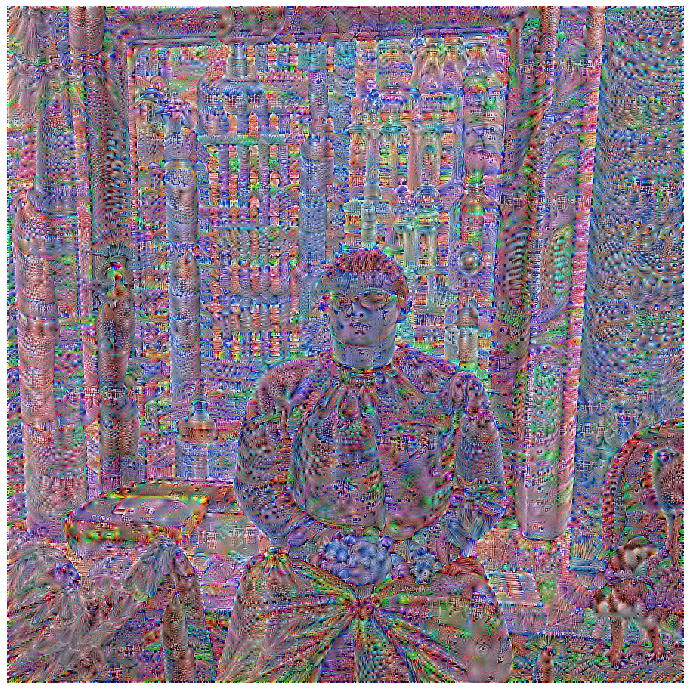

In [47]:
# With art-trained model
img = get_image_from_model(model)
show_image(img)

# Version 2: Unconstrained top-level

In [188]:
width = height = 224

In [189]:
tf.keras.backend.clear_session()

In [190]:
# Load the model
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
# base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### Unconstrained VGG19 top-level Dream

In [201]:
class_names

array([' Wassily Kandinsky', 'Albrecht Durer', 'Amedeo Modigliani',
       'Andy Warhol', 'Claude Monet', 'Cy Twombly', 'Diego Rivera',
       'Diego Velazquez', 'Edgar Degas', 'Edouard Manet', 'Edvard Munch',
       'Edward Hopper', 'Egon Schiele', 'El Greco', 'Fernand Leger',
       'Francisco Goya', 'Georges Seurat', "Georgia O'Keeffe",
       'Gustav Klimt', 'Helen Frankenthaler', 'Henri Matisse',
       'Hieronymus Bosch', 'James McNeill Whistler',
       'Jean-Michel Basquiat', 'Joan Miro', 'John Ruskin',
       'John Singer Sargent', 'John William Waterhouse',
       'Leonardo da Vinci', 'Louis Comfort Tiffany', 'M.C. Escher',
       'Marc Chagall', 'Mark Rothko', 'Mary Cassatt', 'Max Ernst',
       'Michelangelo', 'Norman Rockwell', 'Otto Dix', 'Pablo Picasso',
       'Paul Cezanne', 'Paul Gauguin', 'Paul Klee',
       'Pierre-Auguste Renoir', 'Raphael', 'Rembrandt', 'Rene Magritte',
       'Salvador Dali', 'Sandro Botticelli', 'Thomas Cole', 'Titian',
       'Vincent van Gogh'

In [209]:
from tensorflow.keras.constraints import Constraint

In [231]:
class RemainImage(Constraint):
    def __init__(self, rate = 1.0):
        super().__init__()
        self.rate = rate
    
    def __call__(self, kernel):
        return (self.rate       * tf.clip_by_value(kernel, -150, 150) + 
                (1 - self.rate) * kernel)

In [293]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image')#, kernel_constraint = RemainImage(0.1))

signal = image_layer(input_)

output_layers = {
    'masked_activations' : 1.0,
    'dense_2'            : 0.01,
    'block3_conv4'       : 0.001
}

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
#         activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn

# Layer to mask for only certain artists
artist_vector   = tf.convert_to_tensor(class_names == 'Titian', dtype = tf.float32) * 1
artist_selector = lambda activations : tf.tensordot(activations, artist_vector, [-1, -1])
mask_layer      = Lambda(artist_selector, name = 'masked_activations')
include_artist_mask = True

output_count    = 0

for layer in base_model.layers + [mask_layer]:
    if isinstance(layer, InputLayer):
        continue
    elif isinstance(layer, Dropout):
        continue
    elif isinstance(layer, MaxPooling2D):
        layer = AvgPool2D().from_config(layer.get_config())
    elif layer.name == 'dense_2':
        # Top layer requires different activations
        top_config = layer.get_config()
        top_config['activation'] = 'elu'
        top_layer = layer
        layer     = layer.from_config(top_config)
    elif layer.name == 'masked_activations':
        if not include_artist_mask:
            continue

    signal = layer(signal)
    if layer.name in output_layers:
        output_count += 1
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]), name = f'compute_gain_{output_count}')
        total_activation = summarizer_layer(signal)
        outputs.append(total_activation)
                
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)
    

model = Model(inputs = input_, outputs = final_output)

# Weights for the top layer (with artist activations)
#  were reset; restore them
top_layer.set_weights(base_model.layers[-1].get_weights())

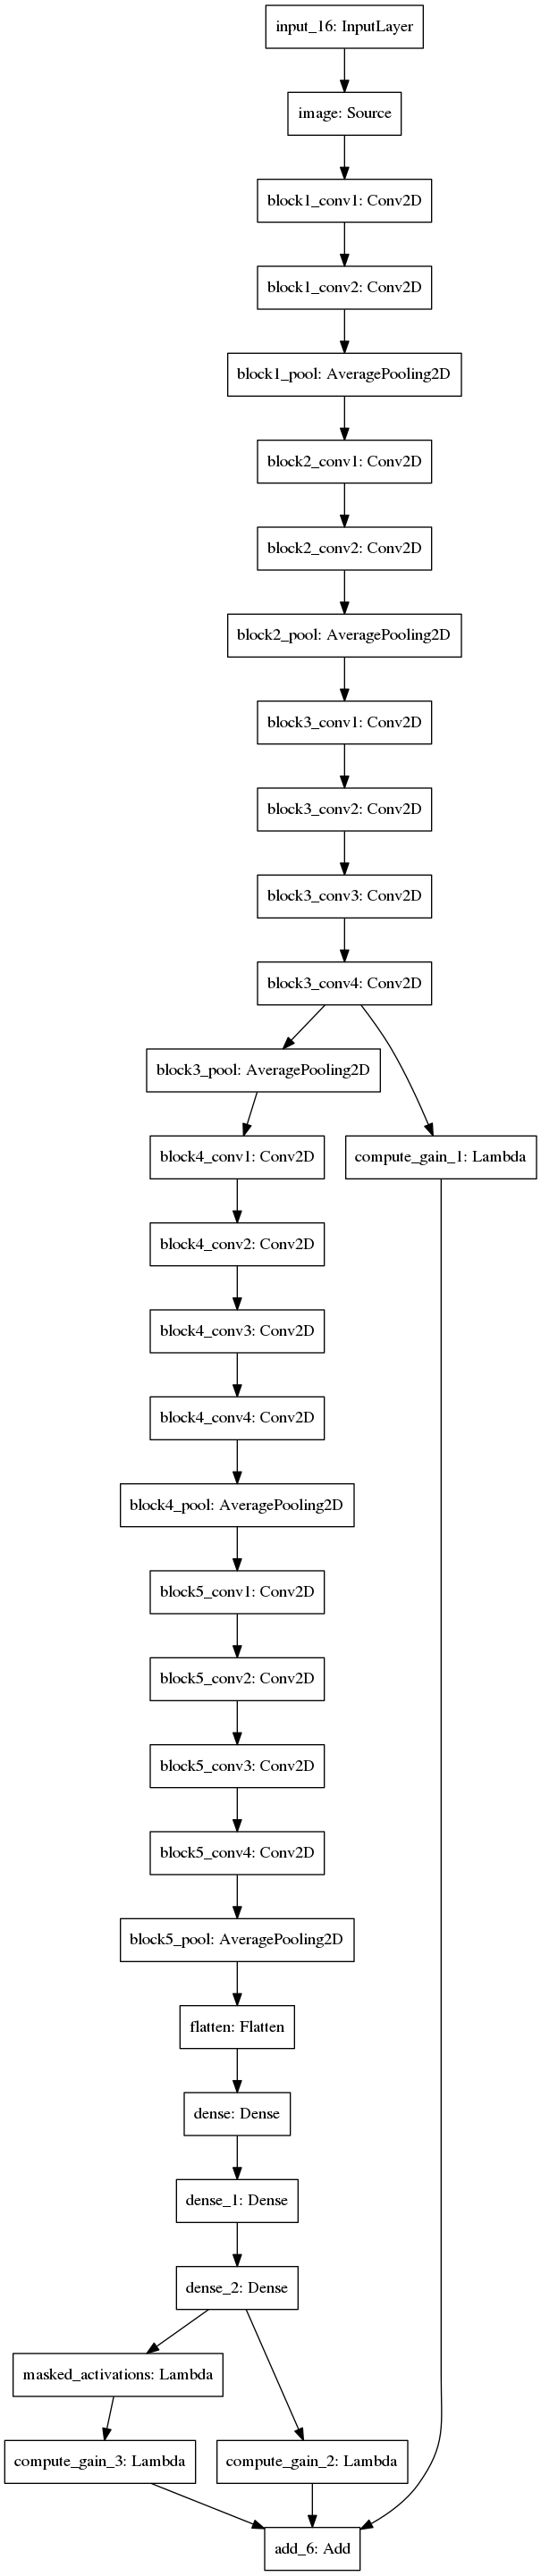

In [294]:
plot_model(model)

In [295]:
# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

In [296]:
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [297]:
adam = tf.optimizers.Adam(learning_rate = 10.0)
model.compile(optimizer = adam, loss = precomputed_loss)
history = model.fit(dummy_input.repeat(10), epochs = 3)

Epoch 1/3
10/10 [==============================] - 1s 101ms/step - loss: -1.9889
Epoch 2/3
10/10 [==============================] - 0s 17ms/step - loss: -18.2664
Epoch 3/3
10/10 [==============================] - 0s 17ms/step - loss: -58.9447


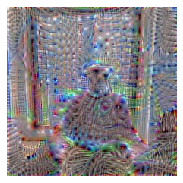

In [298]:
# With art-trained model
img = get_image_from_model(model)
show_image(img)

In [292]:
class_names

array([' Wassily Kandinsky', 'Albrecht Durer', 'Amedeo Modigliani',
       'Andy Warhol', 'Claude Monet', 'Cy Twombly', 'Diego Rivera',
       'Diego Velazquez', 'Edgar Degas', 'Edouard Manet', 'Edvard Munch',
       'Edward Hopper', 'Egon Schiele', 'El Greco', 'Fernand Leger',
       'Francisco Goya', 'Georges Seurat', "Georgia O'Keeffe",
       'Gustav Klimt', 'Helen Frankenthaler', 'Henri Matisse',
       'Hieronymus Bosch', 'James McNeill Whistler',
       'Jean-Michel Basquiat', 'Joan Miro', 'John Ruskin',
       'John Singer Sargent', 'John William Waterhouse',
       'Leonardo da Vinci', 'Louis Comfort Tiffany', 'M.C. Escher',
       'Marc Chagall', 'Mark Rothko', 'Mary Cassatt', 'Max Ernst',
       'Michelangelo', 'Norman Rockwell', 'Otto Dix', 'Pablo Picasso',
       'Paul Cezanne', 'Paul Gauguin', 'Paul Klee',
       'Pierre-Auguste Renoir', 'Raphael', 'Rembrandt', 'Rene Magritte',
       'Salvador Dali', 'Sandro Botticelli', 'Thomas Cole', 'Titian',
       'Vincent van Gogh'

In [ ]:
# dream_model = Sequential([InputLayer(input_shape = (width, height, 3))])
# for layer in base_model.layers[:-1]:
#     # Replace max pool with average pool to promote gradient flow
#     elif isinstance(layer, Dropout):
#         pass
#     else:
#         dream_model.add(layer)
    
